$E_{x\sim p(x|\theta_0)}[q(\theta_0,\theta_1)] ~=~ \int p(x|\theta_0) \cdot q(x|\theta_0, \theta_1) dx$

$~\approx~ \frac{1}{N} \sum_{x\sim p(x|\theta_0)} q(x|\theta_0, \theta_1)$

In [1]:
import numpy       as np
from   scipy       import stats
from   iminuit     import Minuit
from   matplotlib  import pyplot as plt

In [2]:
f1_true     = 0.7
mu1_true    = -12
sigma1_true = 7.

f2_true     = 0.3
mu2_true    = 3
sigma2_true = 4.

N_per_mu    = 50

In [12]:
def pdf (x, mu2_hyp) :
    pdf_1 = f1_true*stats.norm.pdf(x, mu1_true, sigma1_true)
    pdf_2 = f2_true*stats.norm.pdf(x, mu2_hyp , sigma2_true)
    return pdf_1 + pdf_2

def dpdf_dx (x, mu2_hyp) :
    pdf_1 = f1_true*stats.norm.pdf(x, mu1_true, sigma1_true)
    pdf_2 = f2_true*stats.norm.pdf(x, mu2_hyp , sigma2_true)
    return (mu1_true-x)*pdf_1/(sigma1_true*sigma1_true) + (mu2_hyp-x)*pdf_2/(sigma2_true*sigma2_true)

def q (x, mu2_hyp, mu2_ref) :
    return -2.*np.log(pdf(x, mu2_hyp)/pdf(x, mu2_ref))

def q_exp (x, mu2_hyp, mu2_ref) :
    return pdf(x, mu2_ref) * q(x, mu2_hyp, mu2_ref)

def q_exp_alt (x, mu2_hyp, mu2_ref) :
    return pdf(x, mu2_hyp) * q(x, mu2_hyp, mu2_ref)

def dq_dx (x, mu2_hyp, mu2_ref) :
    return -2. * ( (dpdf_dx(x,mu2_hyp)/pdf(x,mu2_hyp)) - (dpdf_dx(x,mu2_ref)/pdf(x,mu2_ref)) )

def importance (x, mu2_hyp, mu2_ref) :
    return pdf (x, mu2_ref) * dq_dx (x, mu2_hyp, mu2_ref)

def sample_pdf1 (num, mu=None) :
    if type(mu) == type(None) :
        mu = mu1_true
    return mu + sigma1_true*np.random.normal(size=(num,))

def sample_pdf2 (num, mu=None) :
    if type(mu) == type(None) :
        mu = mu2_true
    return mu + sigma2_true*np.random.normal(size=(num,))

def sample (num) :
    num1 = int(num*f1_true)
    num2 = num - num1
    ds1, ds2 = sample_pdf1(num1), sample_pdf2(num2)
    ds = np.concatenate([ds1, ds2])
    np.random.shuffle(ds)
    return ds

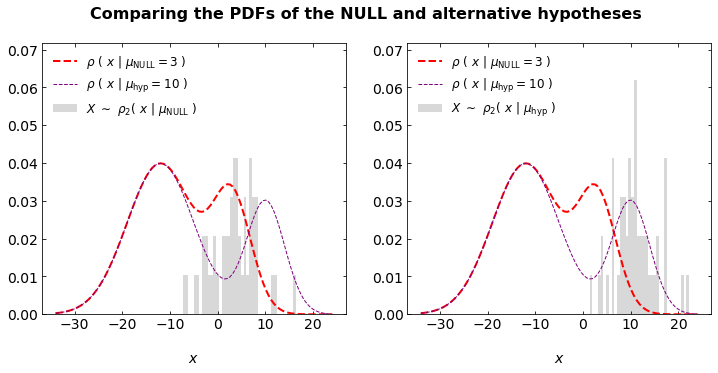

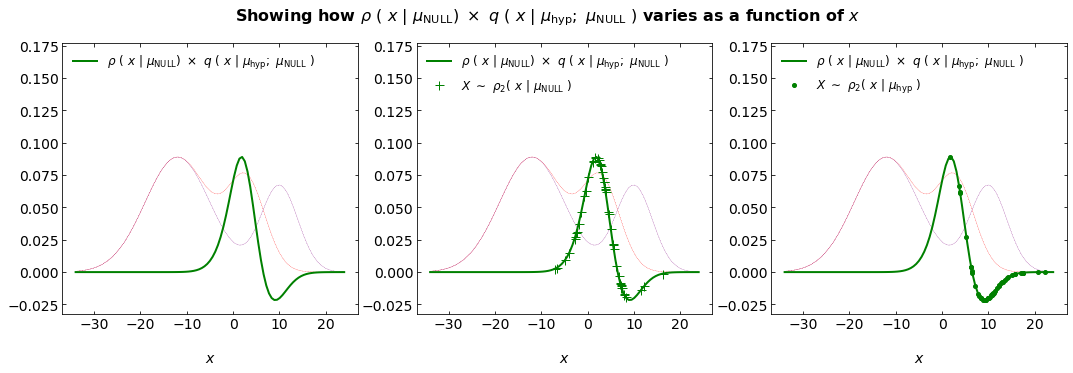

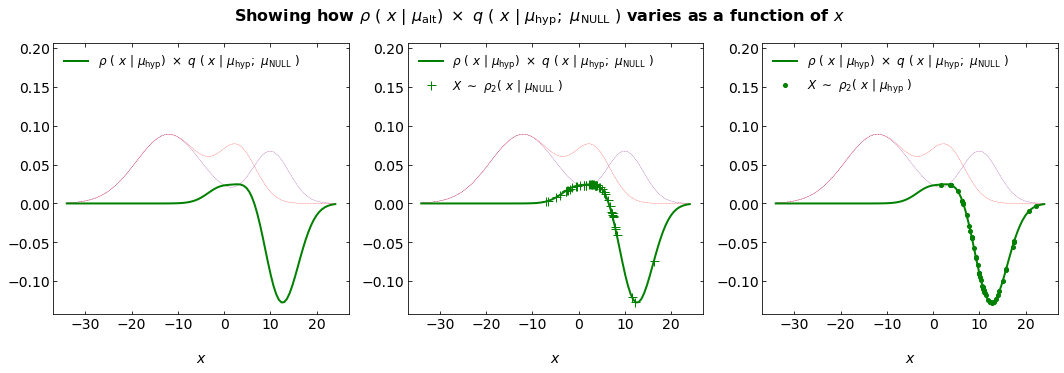

In [21]:
mu2_hyp = 10

bins              = np.linspace(-34, 24, 101)
pdf_profile       = pdf       (bins, mu2_true)
pdf_profile_hyp   = pdf       (bins, mu2_hyp )
imp_profile       = importance(bins, mu2_hyp, mu2_true)
q_profile         = q         (bins, mu2_hyp, mu2_true)
dq_profile        = dq_dx     (bins, mu2_hyp, mu2_true)
q_exp_profile     = q_exp     (bins, mu2_hyp, mu2_true)
q_exp_alt_profile = q_exp_alt (bins, mu2_hyp, mu2_true)

pdf_max                      = np.max(np.concatenate([pdf_profile, pdf_profile_hyp]))
q_exp_min, q_exp_max         = np.min(q_exp_profile), np.max(q_exp_profile)
q_exp_range                  = q_exp_max - q_exp_min
q_exp_alt_min, q_exp_alt_max = np.min(q_exp_alt_profile), np.max(q_exp_alt_profile)
q_exp_alt_range              = q_exp_alt_max - q_exp_alt_min
dataset_hyp                  = sample_pdf2(N_per_mu, mu2_hyp)
dataset_true                 = sample_pdf2(N_per_mu)

fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(1, 2, 1)
ax.hist(dataset_true, bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.0f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.0f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 2, 2)
ax.hist(dataset_hyp , bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.0f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.0f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle("Comparing the PDFs of the NULL and alternative hypotheses", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp(dataset_true, mu2_hyp, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp(dataset_hyp , mu2_hyp, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp_alt(dataset_true, mu2_hyp, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp_alt(dataset_hyp , mu2_hyp, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm alt})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()


In [ ]:
'''plt.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2)
plt.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1)
plt.plot(bins, q_profile     * np.max(pdf_profile) / np.max(np.fabs(q_profile    )), "--", c="gold", linewidth=1)
plt.plot(bins, dq_profile    * np.max(pdf_profile) / np.max(np.fabs(dq_profile   )), "--", c="gold", linewidth=1)
plt.plot(bins, imp_profile   * np.max(pdf_profile) / np.max(np.fabs(imp_profile  )), "-.", c="r", linewidth=1)
plt.show()'''